# Likelihood based approaches

In this tutorial, we implement the maximum likelihood estimation approach and compare with variogram
fitting.

In [5]:
#Preamble 
import pandas as pd
import numpy as np
import gstlearn as gl
import gstlearn.plot as gp
import scipy as sc 
import matplotlib.pyplot as plt
np.random.seed(123134)

## Zero mean stationary GRF model

We first define a zero mean GRF $Z$ model through its covariance function:

In [2]:
# Creation of the coordinates
ndat = 200
x=np.random.uniform(size=ndat)
y=np.random.uniform(size=ndat)
dbsim = gl.Db.create()
dbsim["x"]=x
dbsim["y"]=y
dbsim.setLocators(["x","y"],gl.ELoc.X)

# Creation of the covariance model
rangeval = 0.3
model1 = gl.Model.createFromParam(gl.ECov.SPHERICAL,range = rangeval)

#Simulation of a data set
err=gl.simtub(None,dbsim,model=model1,nbtuba=1000)

#Split train and test (proportion 50%)
ind = np.arange(ndat)
np.random.shuffle(ind)
indtrain = ind[:int(ndat/2)]
indtest  = ind[int(ndat/2):]
dbtrain = gl.Db.createReduce(dbsim,ranks = indtrain)
dbtest = gl.Db.createReduce(dbsim,ranks = indtest)

In [6]:
jura_all = pd.read_csv("jura/jura_pred.csv")
grid = pd.read_csv("jura/jura_grid.csv")

In [ ]:
## Replace landuse interger code by name
landuse_codes=[1,2,3,4]
landuse_names=["Forest","Pasture","Meadow","Tillage"]
jura_all["Landuse"]=jura_all["Landuse"].replace(landuse_codes,landuse_names)

## Replace rock type interger code by name
rock_codes=[1,2,3,4,5]
rock_names=["Argovian","Kimmeridgian","Sequanian","Portlandian","Quaternary"]
jura_all["Rock"]=jura_all["Rock"].replace(rock_codes,rock_names)

## Empirical variogram approach

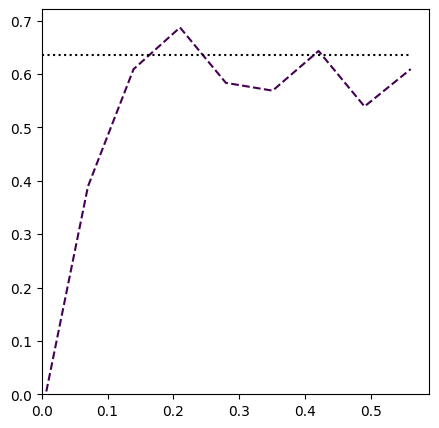

In [3]:
varioParamOmni = gl.VarioParam.createOmniDirection(npas=9, dpas=0.07, toldis=0.1)
vario = gl.Vario.computeFromDb(varioParamOmni,dbtrain)
gp.plot(vario)

In [25]:
fitmod = gl.Model()
err = fitmod.fit(vario)
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =      0.611
- Range        =      0.154
Total Sill     =      0.611
Known Mean(s)     0.000

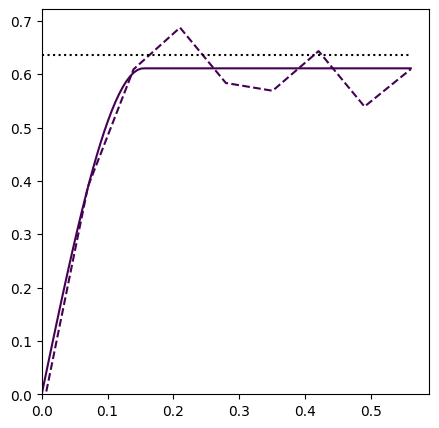

In [26]:
ax = gp.varmod(vario, fitmod)

### Evaluation of the covariance matrix

We use the method **evalCovMatrix** of the class **gl.Model**. The result is of type **gl.Matrix**. We use the method **gl.Matrix.toTL**  to transform it into a **np.array** (**toTL** helps you to transform an object of **gstlearn** into the Target Language, here python).

In [27]:
covmat = fitmod.evalCovMatrix(dbtrain).toTL()
covmat

array([[0.61105869, 0.        , 0.        , ..., 0.        , 0.06361092,
        0.        ],
       [0.        , 0.61105869, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.61105869, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.61105869, 0.        ,
        0.        ],
       [0.06361092, 0.        , 0.        , ..., 0.        , 0.61105869,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.61105869]])

Here we define the likelihood function

In [ ]:
def neg2logLikelihood(db,model,sigma,theta,beta = 0.,X=None):
    ndat = db.getSampleNumber()
    if X is None:
        X = np.ones(shape=(ndat,1))
            
    model.getCova(0).setRangeIsotropic(theta)
    model.getCova(0).setSill(sigma**2)
    z = dbtrain.getColumnByLocator(gl.ELoc.Z)
    betavect = np.atleast_1d(beta)
    C = model.evalCovMatrix(dbtrain).toTL()
    logdet = np.linalg.slogdet(C)[1]
    Zc = z - F@betavect
    CmlZc = np.linalg.solve(C, Zc)
    quad = Zc.T@CmlZc
    return logdet + quad

In [29]:
modelMLE = fitmod.clone()
neg2logLikelihood(dbtrain,modelMLE,0.5,0.2,0.)

Ellipsis

In [30]:
def neg2logLikelihoodForOptim(params,db,model,X=None):
    sigma = params[0]
    theta = params[1]
    beta = params[2:]  
    result = neg2logLikelihood(db,model,sigma,theta,beta,X)
    print("sill " +        str(np.round(sigma**2,2)) + 
          " range " +      str(np.round(theta,2)) +
          " mean " +       str(np.round(beta,2)) + 
          " likelihood " + str(np.round(result,2)))
    return result

def fitMLE(params,db,model,X = None):
    bds = ((0.00001,10),(0.00001,10)) + tuple((None, None) for _ in range(len(params)-2))
    return sc.optimize.minimize(neg2logLikelihoodForOptim,params,
                                args = (db,model,X),
                                bounds= bds)
                                
    
result = fitMLE(np.array([1,0.1,0.]),dbtrain,modelMLE)

TypeError: unsupported operand type(s) for *: 'ellipsis' and 'float'

In [ ]:
modelMLE

Estimated parameters 

In [31]:
result.x

NameError: name 'result' is not defined

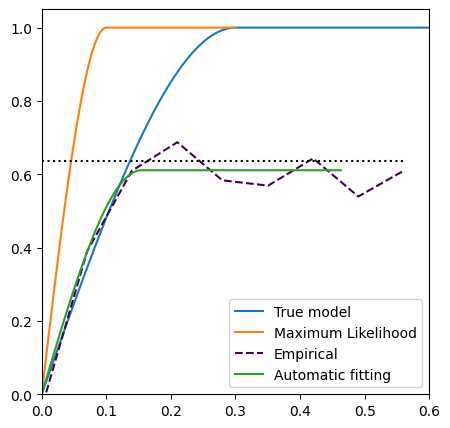

In [32]:
gp.plot(model1,label="True model")
gp.plot(modelMLE,label="Maximum Likelihood")
gp.plot(vario,label="Empirical")
gp.plot(fitmod,label="Automatic fitting")
plt.xlim([0,0.6])
aa=plt.legend()


Comparison with the Simple kriging with the mean estimated by maximum likelihood and ordinary kriging with the fitted model

In [33]:
modelMLE.setMean(result.x[2])

NameError: name 'result' is not defined

In [34]:
gl.kriging(dbtrain,dbtest,modelMLE,gl.NeighUnique(),namconv=gl.NamingConvention("MLE"))

0

In [35]:
fitmod.setDriftIRF(0)
gl.kriging(dbtrain,dbtest,fitmod,gl.NeighUnique(),namconv=gl.NamingConvention("OK"))

0

In [36]:
krigingVario = dbtest["MLE*estim"]
krigingMLE = dbtest["OK*estim"]

In [37]:
print("MSE with MLE " + str(np.mean((krigingMLE-dbtest["Simu"])**2)))
print("MSE with vario " + str(np.mean((krigingVario-dbtest["Simu"])**2)))

MSE with MLE 0.46104545156230237
MSE with vario 0.5956473314860293


## First order non stationary GRF model

We now add a trend term $Z_2(x, y) = a + bx + cy + Z(x, y)$

In [38]:
beta = np.array([1,2,3])

#We duplicate the coordinates and affect them the role of a drift (locator F)
dbsim["v1"] = dbsim["x"]
dbsim["v2"] = dbsim["y"]
dbsim.setLocators(["v*"],gl.ELoc.F)

X = np.hstack([np.ones(shape=(ndat,1)),dbsim["v*"]]) #We stack a column of ones

#We add the total drift to the GRF
dbsim["Simu"] = X@beta + dbsim["Simu"]

#Split as previously
dbtrain = gl.Db.createReduce(dbsim,ranks = indtrain)
dbtest = gl.Db.createReduce(dbsim,ranks = indtest)

In [39]:
#We specify to the model that there are two drift variables
fitmod.setDriftIRF(nfex = 2)
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 3
Number of drift equation(s)  = 3

Covariance Part
---------------
Spherical
- Sill         =      0.611
- Range        =      0.154
Total Sill     =      0.611

Drift Part
----------
Universality_Condition
External_Drift:0
External_Drift:1

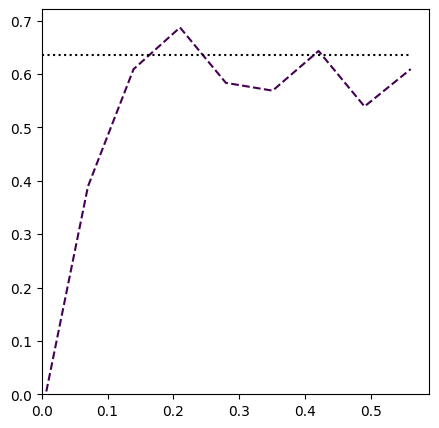

In [40]:
#Variogram of the residuals
varioKED =gl.Vario.computeFromDb(varioParamOmni,dbtrain,model=fitmod)
gp.plot(vario)

In [41]:
result = fitMLE(np.array([1,0.1,0.,0.,0.]),dbtrain,modelMLE,X[indtrain,:])

TypeError: unsupported operand type(s) for *: 'ellipsis' and 'float'

In [131]:
gl.kriging(dbtrain,dbtest,fitmod,gl.NeighUnique(),namconv=gl.NamingConvention("KED"))

0

Kriging (residuals) by using the maximul likelihood estimations.

In [132]:
#Computation of the residuals
dbtrain["residual"] =  dbtrain["Simu"]-X[indtrain,:]@result.x[2:]
dbtrain.setLocator("residual",gl.ELoc.Z)
modelMLE.setMean(0)
gl.kriging(dbtrain,dbtest,modelMLE,gl.NeighUnique(),namconv=gl.NamingConvention("MLE"))

0

In [133]:
np.mean((dbtest["Simu"]-dbtest["KED*estim"])**2)

0.4329480722126569

In [134]:
dbtest["krigingMLE"] = dbtest["MLE.residual.estim"]+ X[indtest,:]@result.x[2:]

In [135]:
np.mean((dbtest["Simu"]-dbtest["krigingMLE"])**2)

0.32228918406591395

## Exercises

1. Repeat the procedure for 100 simulations for both models and methods. Print a table containing the mean and
standard deviation of the estimated parameter values and the MSEs.
2. Implement the profile log-likelihood